# Analysing Results from Prompt 2 - with Equations (diff)

In [1]:
# =============================================================================
# FRENCH ILI FORECASTING - COMPLETE RESULTS VISUALIZATION WITH DATES
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)


In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

HORIZONS = [2, 4]
RESULTS_BASE = "./results"
DATA_PATH = "epidemics_30years_full.csv"

# Load original data to get dates
print("Loading original data for date alignment...")
data_full = pd.read_csv(DATA_PATH)

# Ensure date column is parsed
if 'date' in data_full.columns:
    data_full['date'] = pd.to_datetime(data_full['date'])
elif 'Date' in data_full.columns:
    data_full['date'] = pd.to_datetime(data_full['Date'])
else:
    print("WARNING: No date column found. Creating synthetic dates.")
    data_full['date'] = pd.date_range(start='1994-01-01', periods=len(data_full), freq='W')

print(f"✓ Data loaded: {len(data_full)} weeks from {data_full['date'].min()} to {data_full['date'].max()}")
print()


Loading original data for date alignment...
✓ Data loaded: 1590 weeks from 1990-01-01 00:00:00 to 2019-12-31 00:00:00



In [3]:
# =============================================================================
# LOAD RESULTS AND ALIGN WITH DATES
# =============================================================================

results = {}

# Standard train/val/test split: 70/20/10
train_ratio = 0.7
val_ratio = 0.2

num_train = int(len(data_full) * train_ratio)
num_val = int(len(data_full) * val_ratio)
num_test = len(data_full) - num_train - num_val

test_start_idx = num_train + num_val

print(f"Dataset split:")
print(f"  Train: {num_train} weeks ({data_full['date'].iloc[0]} to {data_full['date'].iloc[num_train-1]})")
print(f"  Val:   {num_val} weeks ({data_full['date'].iloc[num_train]} to {data_full['date'].iloc[num_train+num_val-1]})")
print(f"  Test:  {num_test} weeks ({data_full['date'].iloc[test_start_idx]} to {data_full['date'].iloc[-1]})")
print()

for horizon in HORIZONS:
    results_dir = Path(RESULTS_BASE) / f"sentinelle_ILI_quick_{horizon}week"
    
    preds = np.load(results_dir / 'predictions.npy')
    trues = np.load(results_dir / 'true_values.npy')
    
    num_samples = preds.shape[0]
    pred_len = preds.shape[1]
    
    print(f"✓ Loaded {horizon}-week results")
    print(f"  Predictions shape: {preds.shape}")
    print(f"  Samples: {num_samples}, Horizon: {pred_len}")
    
    # Calculate dates for each prediction
    seq_len = 26
    dates_list = []
    
    for i in range(num_samples):
        pred_start_idx = test_start_idx + seq_len + i
        sample_dates = []
        
        for h in range(pred_len):
            date_idx = pred_start_idx + h
            if date_idx < len(data_full):
                sample_dates.append(data_full['date'].iloc[date_idx])
            else:
                sample_dates.append(None)
        
        dates_list.append(sample_dates)
    
    # Filter out samples with None dates
    valid_samples = [i for i in range(len(dates_list)) if all(d is not None for d in dates_list[i])]
    
    results[horizon] = {
        'predictions': preds[valid_samples],
        'true_values': trues[valid_samples],
        'dates': [dates_list[i] for i in valid_samples],
        'metrics_path': results_dir / 'metrics.txt',
        'per_horizon_path': results_dir / 'per_horizon_metrics.csv'
    }
    
    if len(valid_samples) > 0:
        print(f"  Valid samples: {len(valid_samples)}")
        print(f"  Date range: {dates_list[valid_samples[0]][0]} to {dates_list[valid_samples[-1]][-1]}")
    print()

Dataset split:
  Train: 1113 weeks (1990-01-01 00:00:00 to 2010-12-31 00:00:00)
  Val:   318 weeks (2011-01-01 00:00:00 to 2016-12-30 00:00:00)
  Test:  159 weeks (2017-01-01 00:00:00 to 2019-12-31 00:00:00)

✓ Loaded 2-week results
  Predictions shape: (3170, 2, 1)
  Samples: 3170, Horizon: 2
  Valid samples: 132
  Date range: 2017-07-02 00:00:00 to 2019-12-31 00:00:00

✓ Loaded 4-week results
  Predictions shape: (3150, 4, 1)
  Samples: 3150, Horizon: 4
  Valid samples: 130
  Date range: 2017-07-02 00:00:00 to 2019-12-31 00:00:00



In [4]:
# =============================================================================
# LOAD METRICS
# =============================================================================

for horizon in HORIZONS:
    print(f"\n{'='*60}")
    print(f"{horizon}-WEEK FORECAST METRICS")
    print('='*60)
    
    with open(results[horizon]['metrics_path'], 'r') as f:
        print(f.read())




2-WEEK FORECAST METRICS
FORECASTING EVALUATION METRICS

Overall Metrics:
------------------------------------------------------------
MAE:   228625.291365
MAPE:  1402099016826310.25%
RMSE:  543117.123374
MSE:   294976209702.544739

Predictions shape: (3170, 2, 1)
True values shape: (3170, 2, 1)


4-WEEK FORECAST METRICS
FORECASTING EVALUATION METRICS

Overall Metrics:
------------------------------------------------------------
MAE:   224318.485400
MAPE:  1027055014675695.75%
RMSE:  497453.205839
MSE:   247459691999.431976

Predictions shape: (3150, 4, 1)
True values shape: (3150, 4, 1)



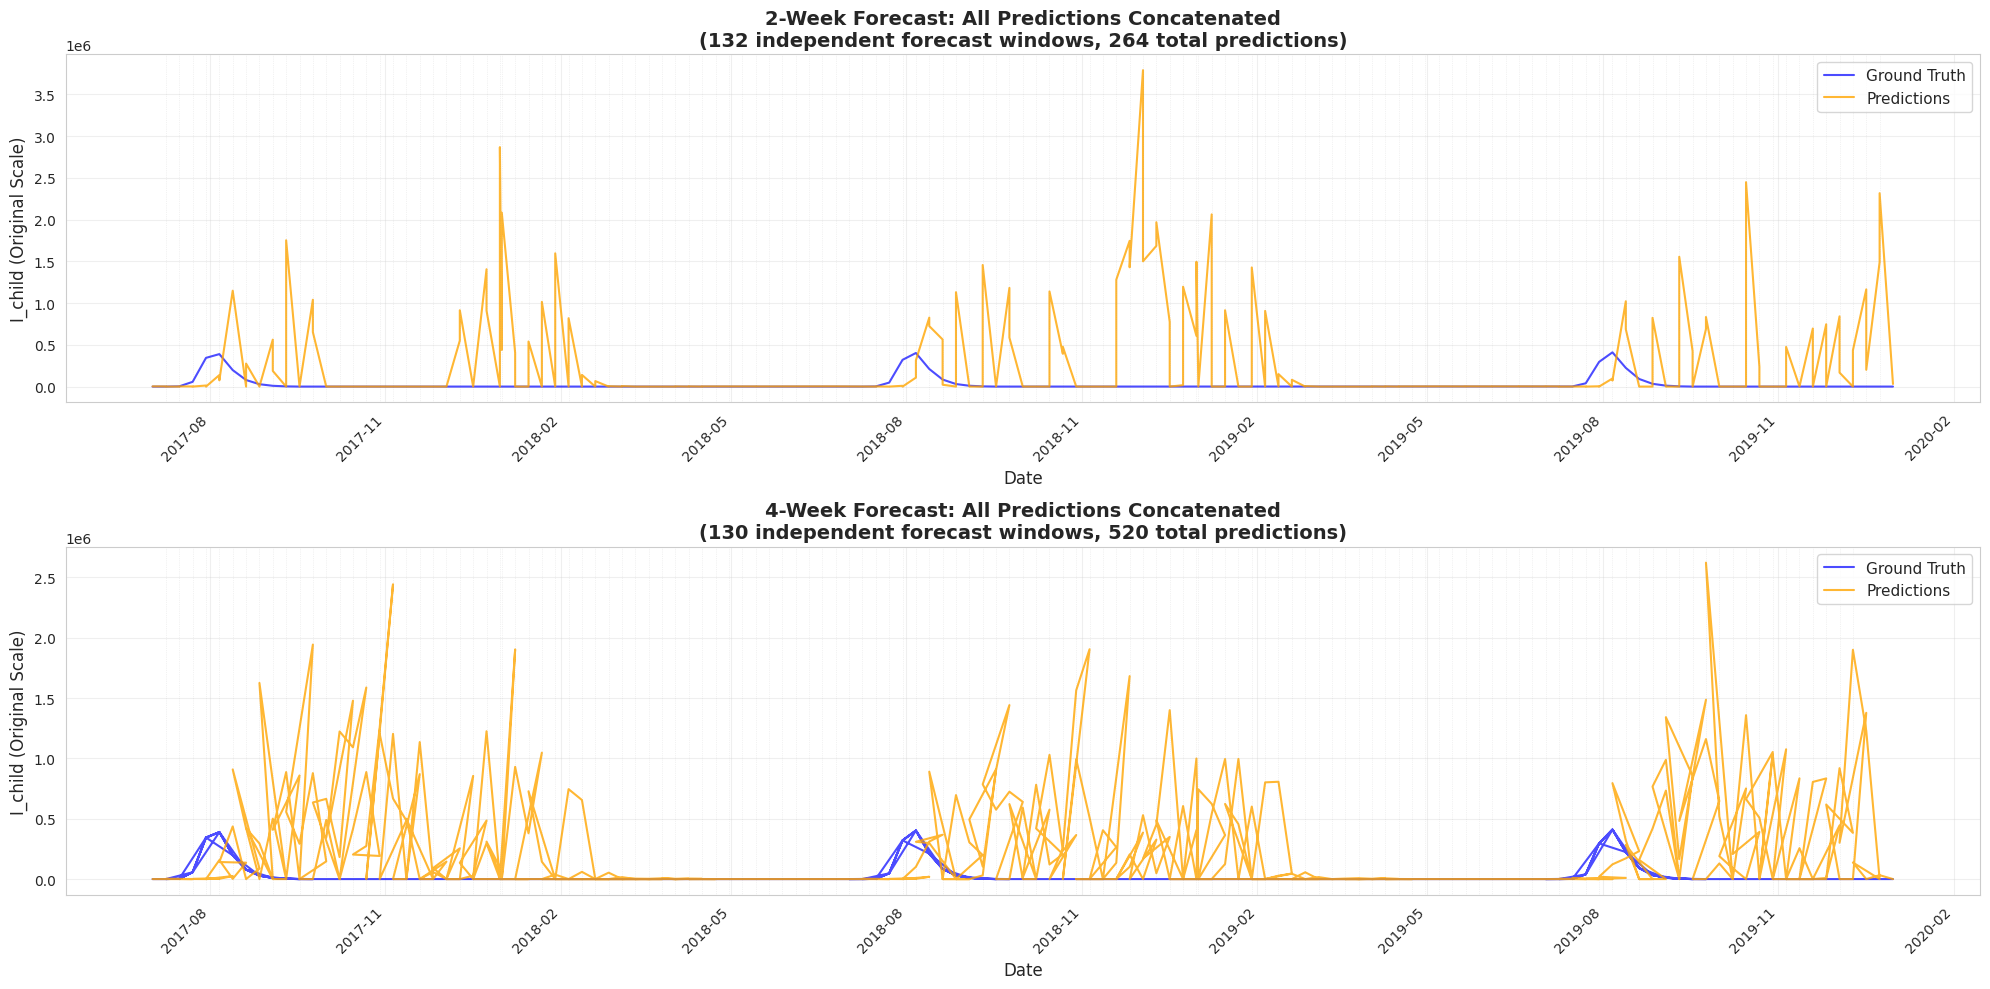

In [5]:
# =============================================================================
# PLOT 1: CONCATENATED TIME SERIES WITH DATES
# =============================================================================

fig, axes = plt.subplots(2, 1, figsize=(20, 10))

for idx, horizon in enumerate(HORIZONS):
    ax = axes[idx]
    
    preds = results[horizon]['predictions']
    trues = results[horizon]['true_values']
    dates = results[horizon]['dates']
    
    # Flatten predictions, trues, and dates (concatenation)
    preds_flat = []
    trues_flat = []
    dates_flat = []
    
    for i in range(len(preds)):
        for h in range(preds.shape[1]):
            preds_flat.append(preds[i, h, 0])
            trues_flat.append(trues[i, h, 0])
            dates_flat.append(dates[i][h])
    
    preds_flat = np.array(preds_flat)
    trues_flat = np.array(trues_flat)
    dates_flat = np.array(dates_flat)
    
    # Plot
    ax.plot(dates_flat, trues_flat, label='Ground Truth', 
            color='blue', linewidth=1.5, alpha=0.7)
    ax.plot(dates_flat, preds_flat, label='Predictions', 
            color='orange', linewidth=1.5, alpha=0.8)
    
    # Add vertical lines at window boundaries
    for i in range(horizon, len(dates_flat), horizon):
        ax.axvline(x=dates_flat[i], color='gray', linestyle=':', alpha=0.2, linewidth=0.5)
    
    ax.set_title(f'{horizon}-Week Forecast: All Predictions Concatenated\n'
                 f'({len(preds)} independent forecast windows, {len(preds_flat)} total predictions)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('I_child (Original Scale)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('./results/comparison_concatenated_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()

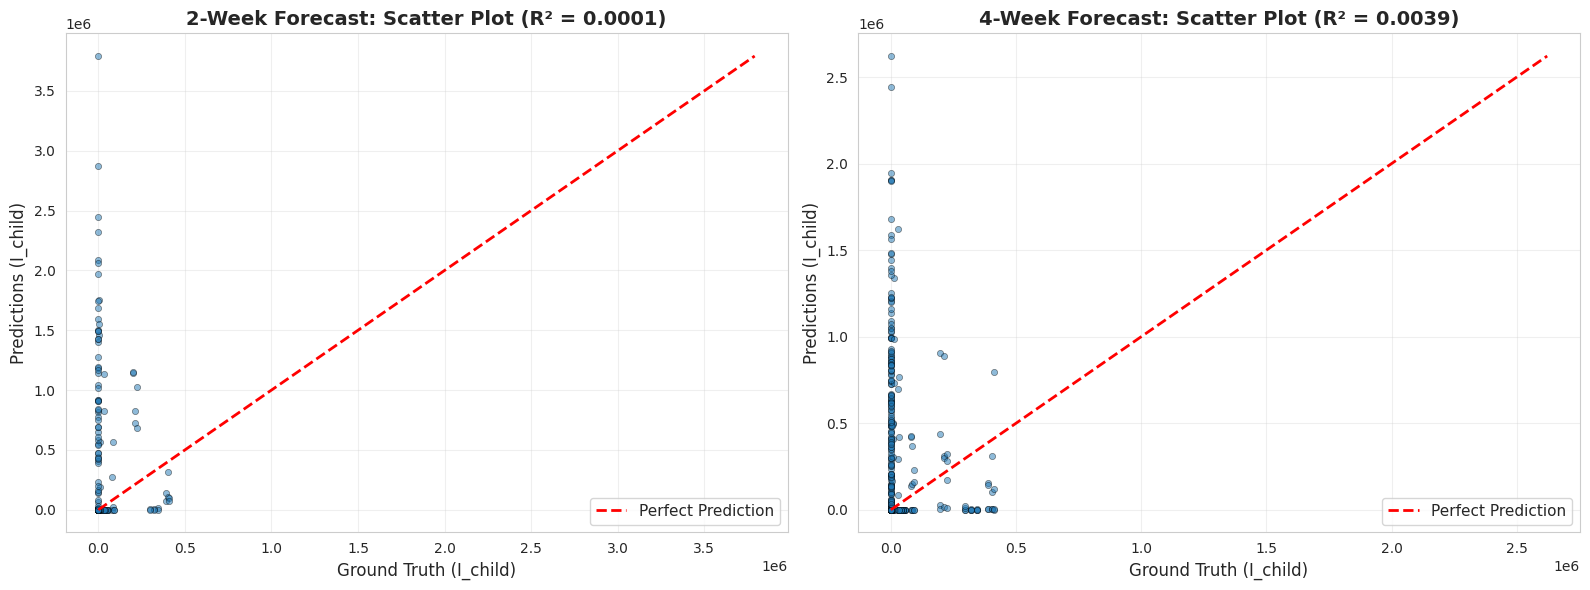

In [6]:
# =============================================================================
# PLOT 2: SCATTER PLOT (PREDICTED VS ACTUAL)
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, horizon in enumerate(HORIZONS):
    ax = axes[idx]
    
    preds = results[horizon]['predictions'].flatten()
    trues = results[horizon]['true_values'].flatten()
    
    ax.scatter(trues, preds, alpha=0.5, s=20, edgecolor='black', linewidth=0.5)
    
    min_val = min(trues.min(), preds.min())
    max_val = max(trues.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    correlation_matrix = np.corrcoef(trues, preds)
    r_squared = correlation_matrix[0, 1] ** 2
    
    ax.set_title(f'{horizon}-Week Forecast: Scatter Plot (R² = {r_squared:.4f})', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Ground Truth (I_child)', fontsize=12)
    ax.set_ylabel('Predictions (I_child)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/comparison_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


2-week Residual Statistics:
  Mean: 241146.6680
  Std:  573240.4790
  Min:  -344031.7021
  Max:  3791265.7364

4-week Residual Statistics:
  Mean: 189974.8316
  Std:  423899.8003
  Min:  -410291.9823
  Max:  2621937.3290


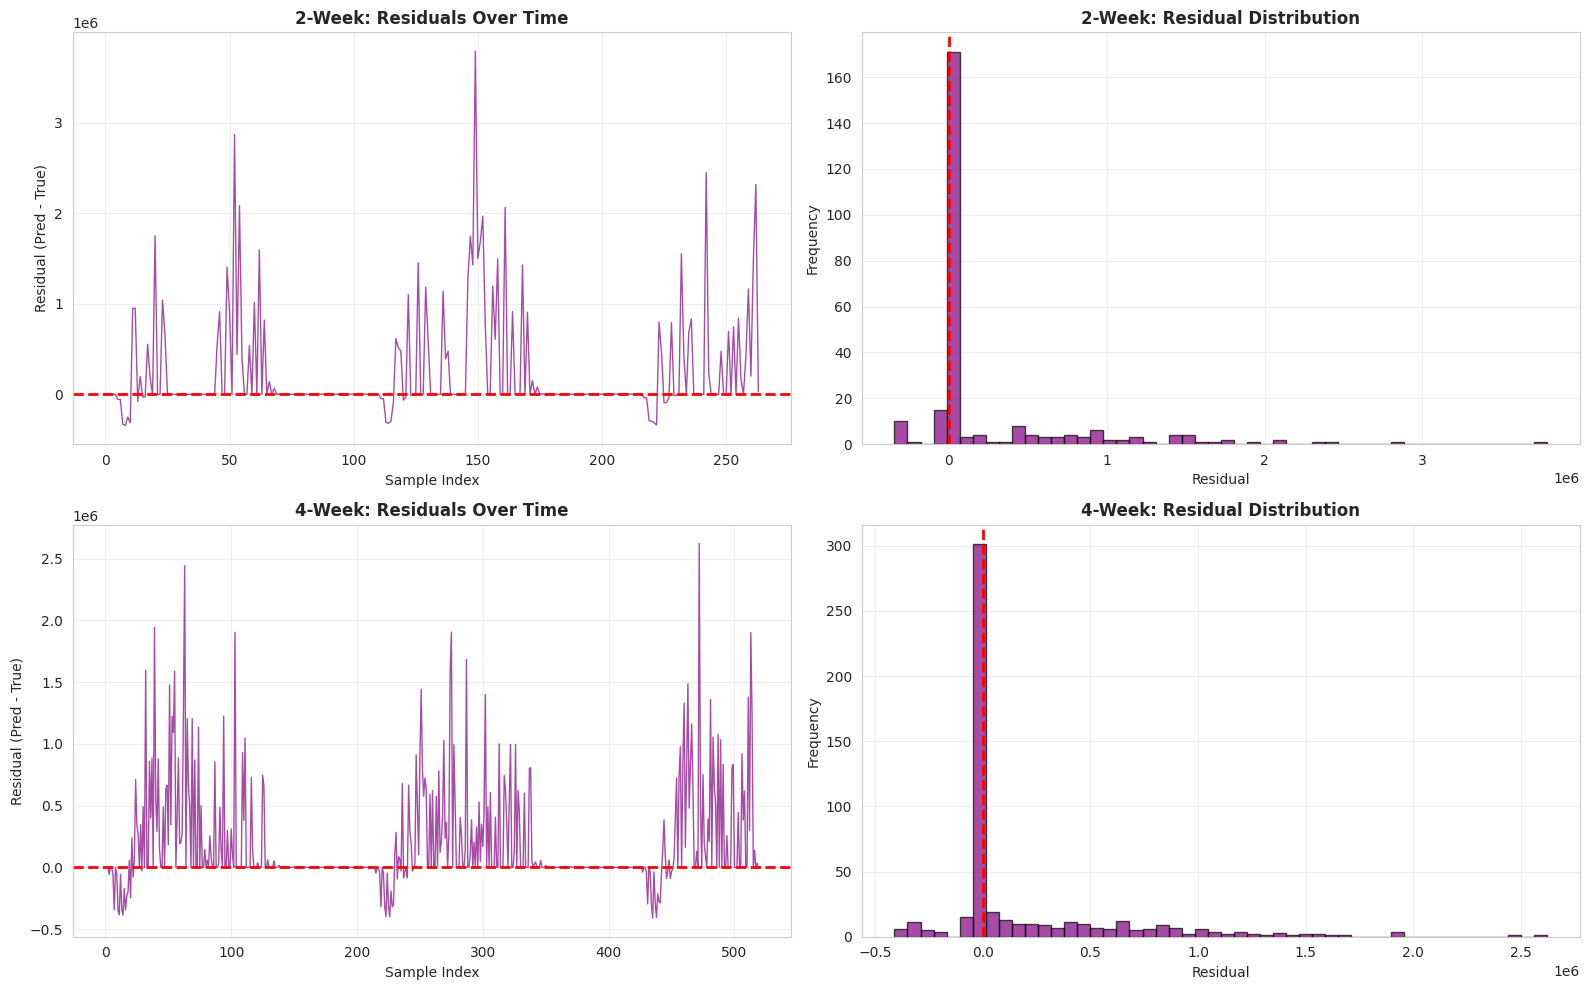

In [7]:
# =============================================================================
# PLOT 3: RESIDUAL ANALYSIS
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, horizon in enumerate(HORIZONS):
    preds = results[horizon]['predictions'].flatten()
    trues = results[horizon]['true_values'].flatten()
    residuals = preds - trues
    
    # Residuals over time
    ax1 = axes[idx, 0]
    ax1.plot(residuals, linewidth=1, alpha=0.7, color='purple')
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax1.set_title(f'{horizon}-Week: Residuals Over Time', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Sample Index', fontsize=10)
    ax1.set_ylabel('Residual (Pred - True)', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Residual histogram
    ax2 = axes[idx, 1]
    ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='purple')
    ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax2.set_title(f'{horizon}-Week: Residual Distribution', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Residual', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    print(f"\n{horizon}-week Residual Statistics:")
    print(f"  Mean: {residuals.mean():.4f}")
    print(f"  Std:  {residuals.std():.4f}")
    print(f"  Min:  {residuals.min():.4f}")
    print(f"  Max:  {residuals.max():.4f}")

plt.tight_layout()
plt.savefig('./results/comparison_residuals.png', dpi=300, bbox_inches='tight')
plt.show()


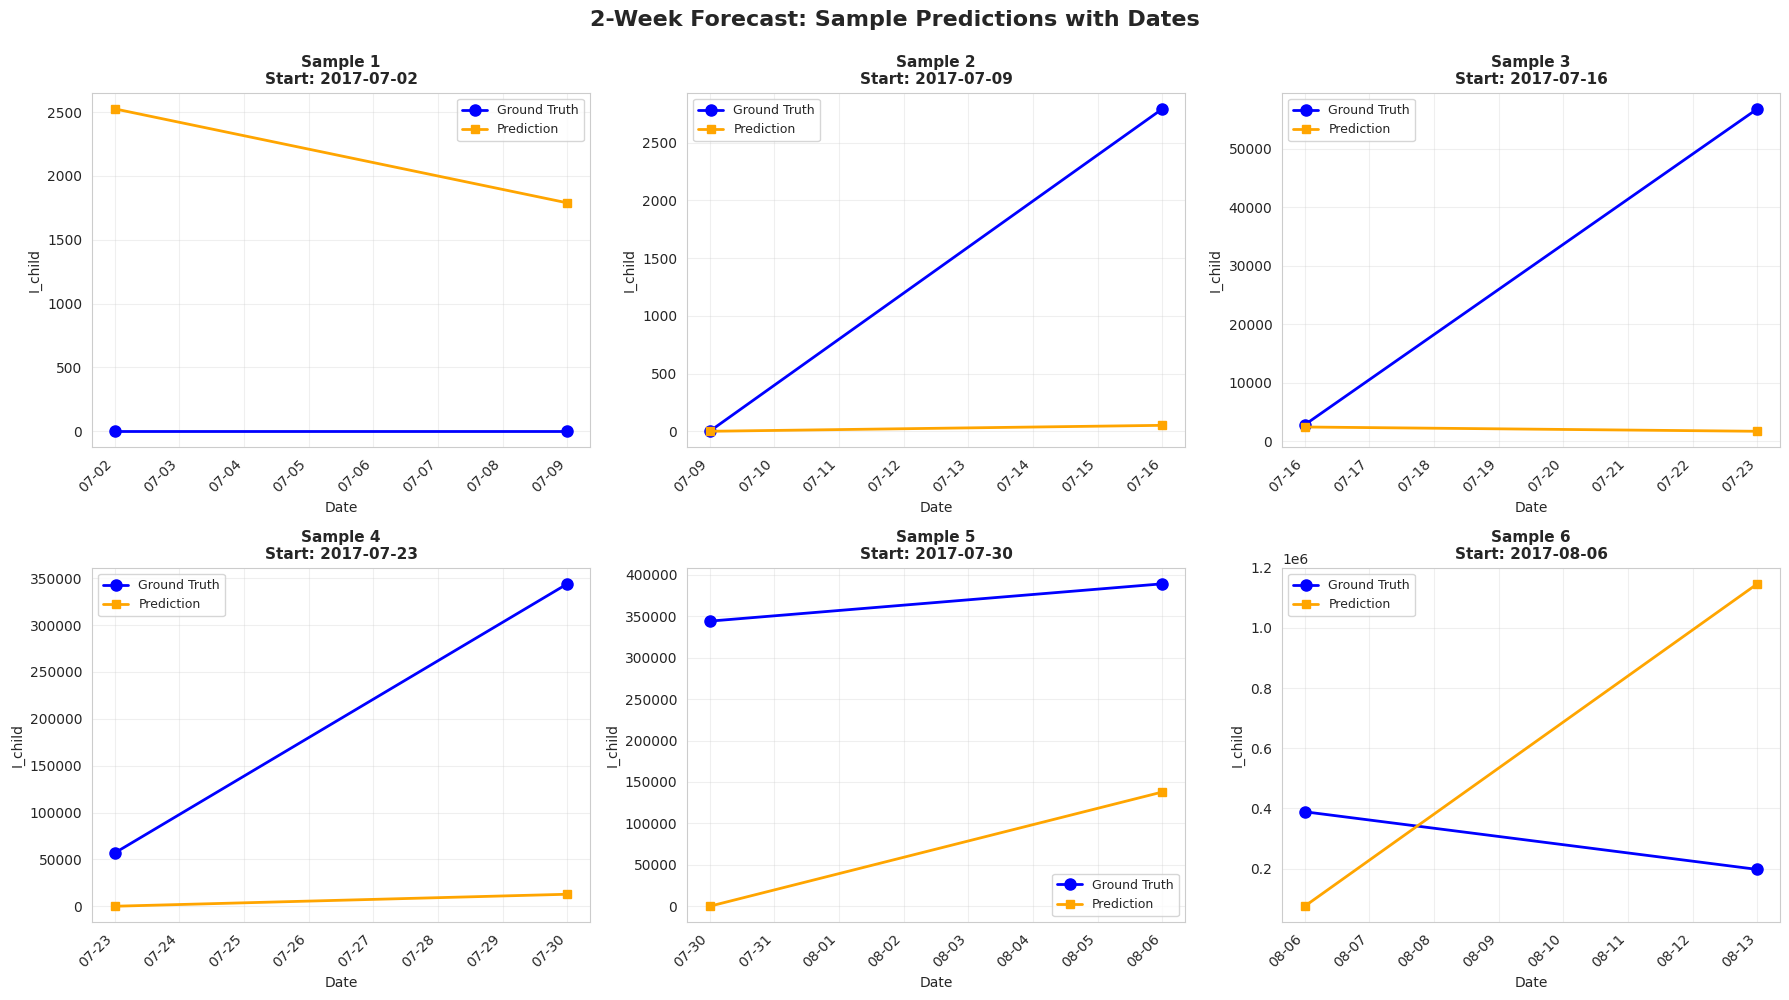

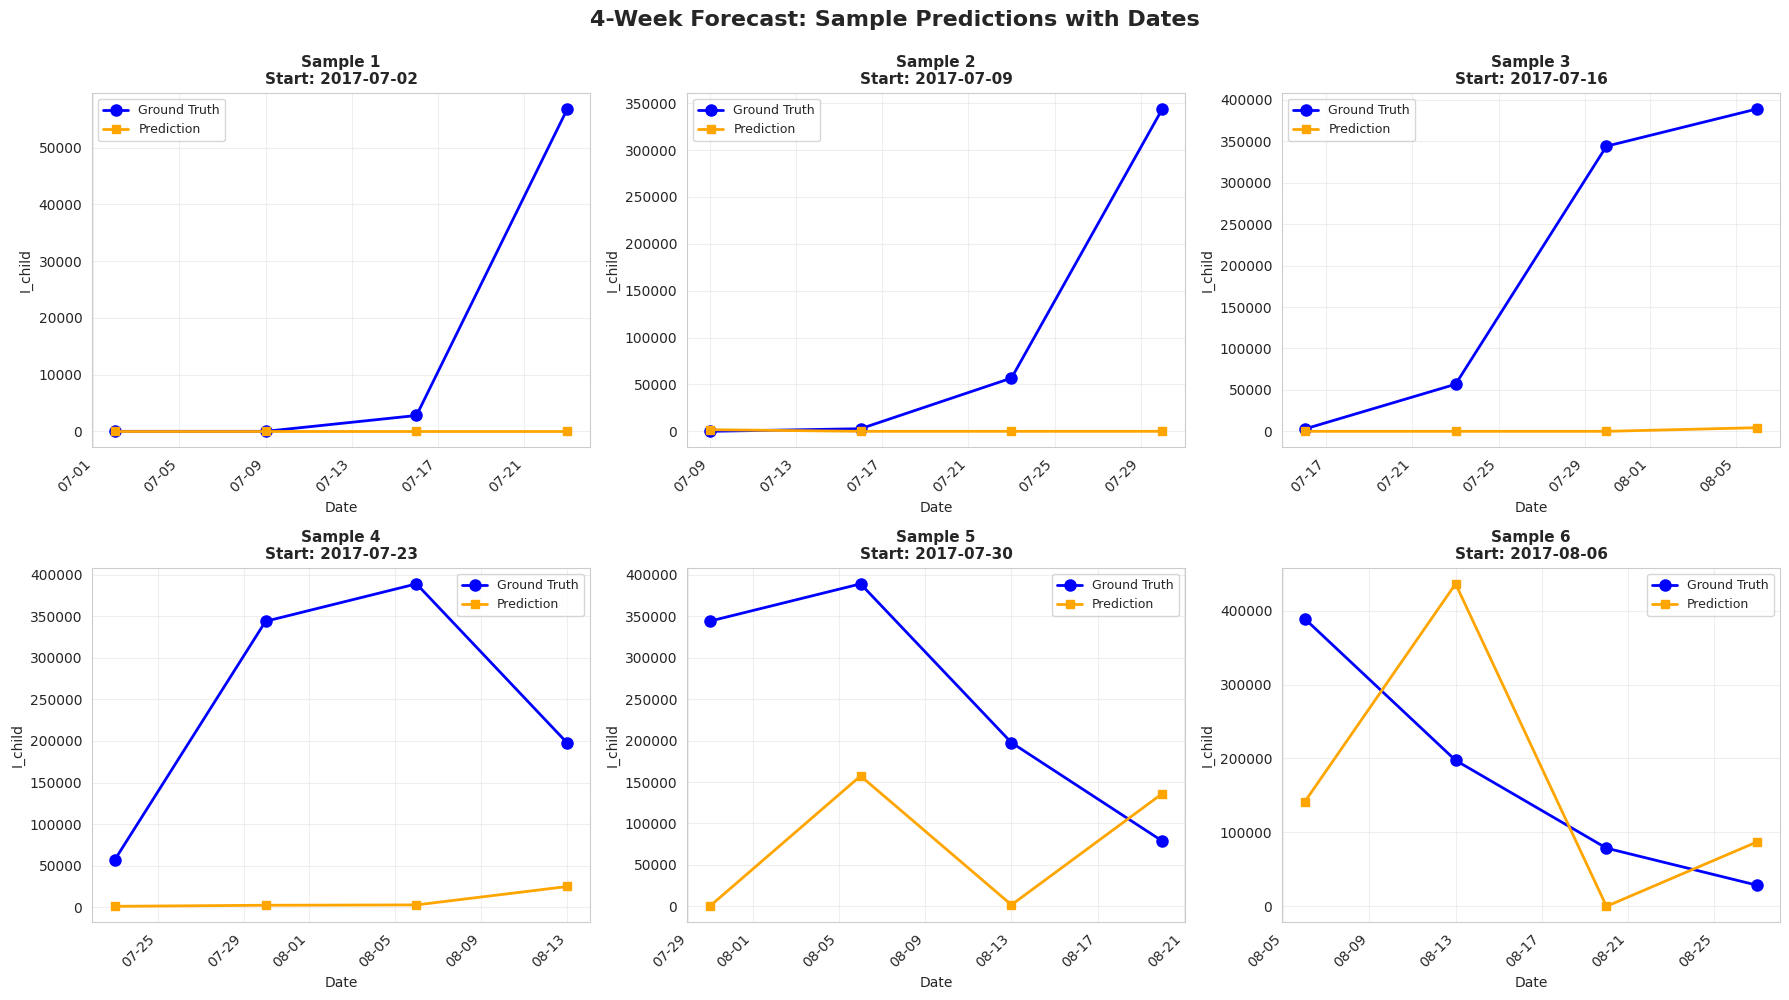

In [8]:
# =============================================================================
# PLOT 4: SAMPLE FORECAST WINDOWS WITH DATES (FIRST 6 EXAMPLES)
# =============================================================================

for horizon in HORIZONS:
    preds = results[horizon]['predictions']
    trues = results[horizon]['true_values']
    dates = results[horizon]['dates']
    
    n_samples = min(6, preds.shape[0])
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i in range(n_samples):
        ax = axes[i]
        
        sample_dates = dates[i]
        
        ax.plot(sample_dates, trues[i, :, 0], 'o-', label='Ground Truth', 
                color='blue', linewidth=2, markersize=8)
        ax.plot(sample_dates, preds[i, :, 0], 's-', label='Prediction', 
                color='orange', linewidth=2, markersize=6)
        
        ax.set_title(f'Sample {i+1}\nStart: {sample_dates[0].strftime("%Y-%m-%d")}', 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('I_child', fontsize=10)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    fig.suptitle(f'{horizon}-Week Forecast: Sample Predictions with Dates', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'./results/comparison_samples_{horizon}week.png', dpi=300, bbox_inches='tight')
    plt.show()

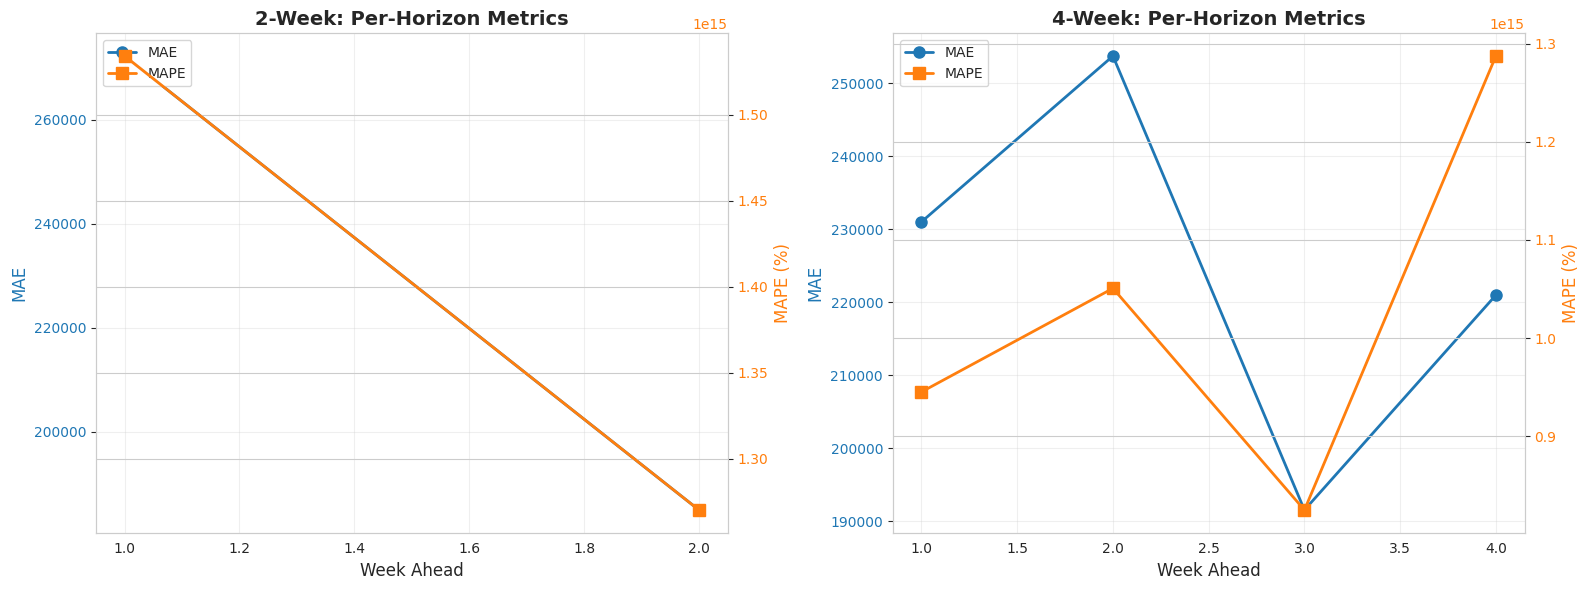

In [9]:
# =============================================================================
# PLOT 5: PER-HORIZON METRICS
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, horizon in enumerate(HORIZONS):
    per_horizon_file = results[horizon]['per_horizon_path']
    
    if per_horizon_file.exists():
        df = pd.read_csv(per_horizon_file)
        
        ax = axes[idx]
        
        if 'MAE' in df.columns and 'MAPE' in df.columns:
            x = df['Horizon'].values if 'Horizon' in df.columns else np.arange(len(df))
            
            color1 = 'tab:blue'
            ax.plot(x, df['MAE'], 'o-', label='MAE', linewidth=2, markersize=8, color=color1)
            ax.set_xlabel('Week Ahead', fontsize=12)
            ax.set_ylabel('MAE', fontsize=12, color=color1)
            ax.tick_params(axis='y', labelcolor=color1)
            ax.grid(True, alpha=0.3)
            
            ax2 = ax.twinx()
            color2 = 'tab:orange'
            ax2.plot(x, df['MAPE'], 's-', label='MAPE', linewidth=2, markersize=8, color=color2)
            ax2.set_ylabel('MAPE (%)', fontsize=12, color=color2)
            ax2.tick_params(axis='y', labelcolor=color2)
            
            ax.set_title(f'{horizon}-Week: Per-Horizon Metrics', fontsize=14, fontweight='bold')
            
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('./results/comparison_per_horizon_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

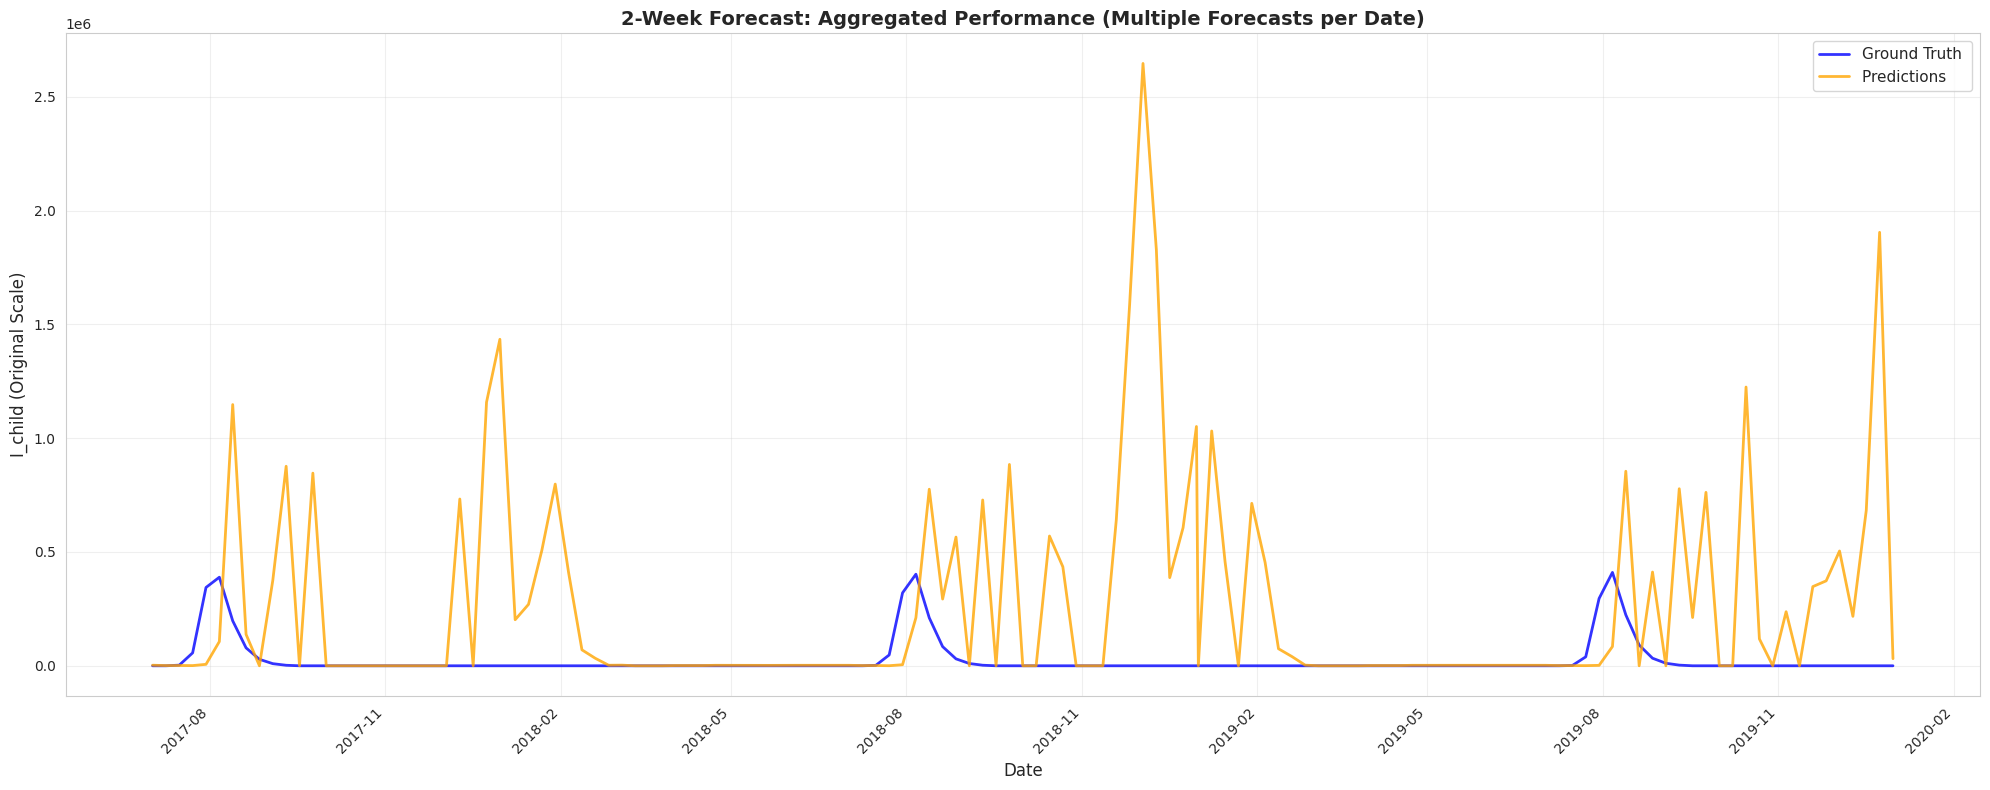

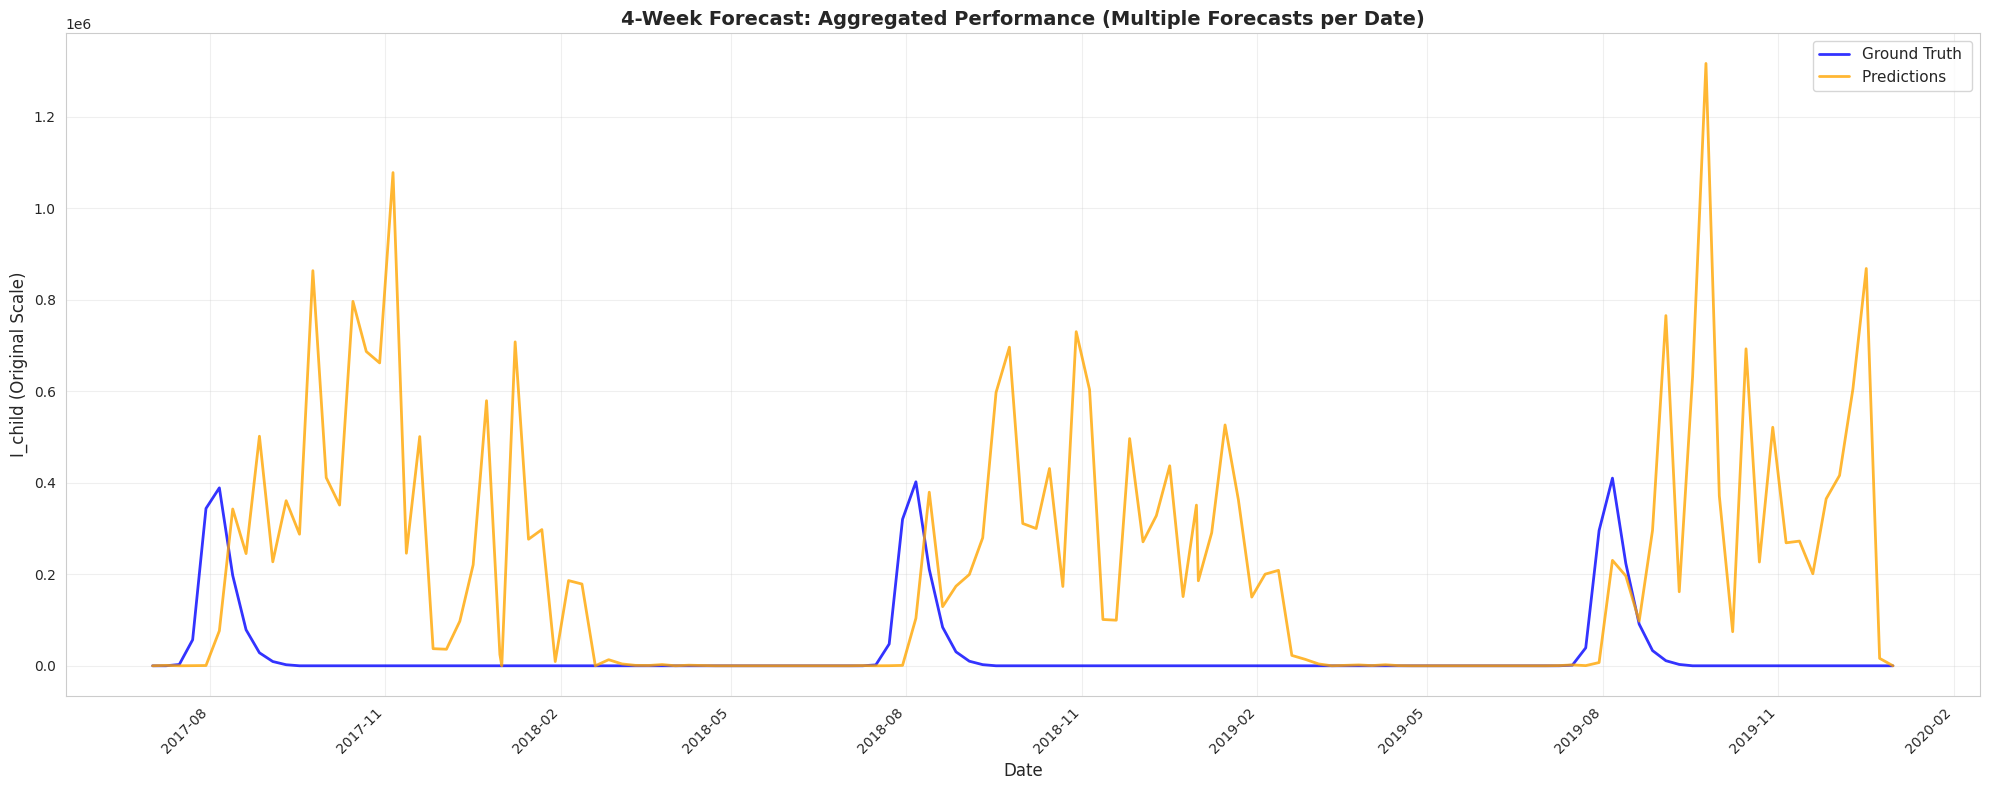

In [13]:
# =============================================================================
# PLOT 6: AGGREGATED TIME SERIES (MEAN + CONFIDENCE BANDS)
# =============================================================================

for horizon in HORIZONS:
    preds = results[horizon]['predictions']
    trues = results[horizon]['true_values']
    dates = results[horizon]['dates']
    
    # Group by date
    date_to_preds = {}
    date_to_trues = {}
    
    for i in range(len(preds)):
        for h in range(preds.shape[1]):
            date = dates[i][h]
            if date not in date_to_preds:
                date_to_preds[date] = []
                date_to_trues[date] = []
            date_to_preds[date].append(preds[i, h, 0])
            date_to_trues[date].append(trues[i, h, 0])
    
    unique_dates = sorted(date_to_preds.keys())
    mean_preds = [np.mean(date_to_preds[d]) for d in unique_dates]
    p25_preds = [np.percentile(date_to_preds[d], 25) for d in unique_dates]
    p75_preds = [np.percentile(date_to_preds[d], 75) for d in unique_dates]
    mean_trues = [np.mean(date_to_trues[d]) for d in unique_dates]
    
    fig, ax = plt.subplots(figsize=(20, 8))
    
    ax.plot(unique_dates, mean_trues, label='Ground Truth ', 
            color='blue', linewidth=2, alpha=0.8)
    ax.plot(unique_dates, mean_preds, label='Predictions ', 
            color='orange', linewidth=2, alpha=0.8)
    #ax.fill_between(unique_dates, p25_preds, p75_preds, 
                     #color='orange', alpha=0.2, label='Prediction IQR (25-75%)')
    
    ax.set_title(f'{horizon}-Week Forecast: Aggregated Performance (Multiple Forecasts per Date)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('I_child (Original Scale)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(f'./results/comparison_aggregated_{horizon}week.png', dpi=300, bbox_inches='tight')
    plt.show()

NameError: name 'summary_data' is not defined

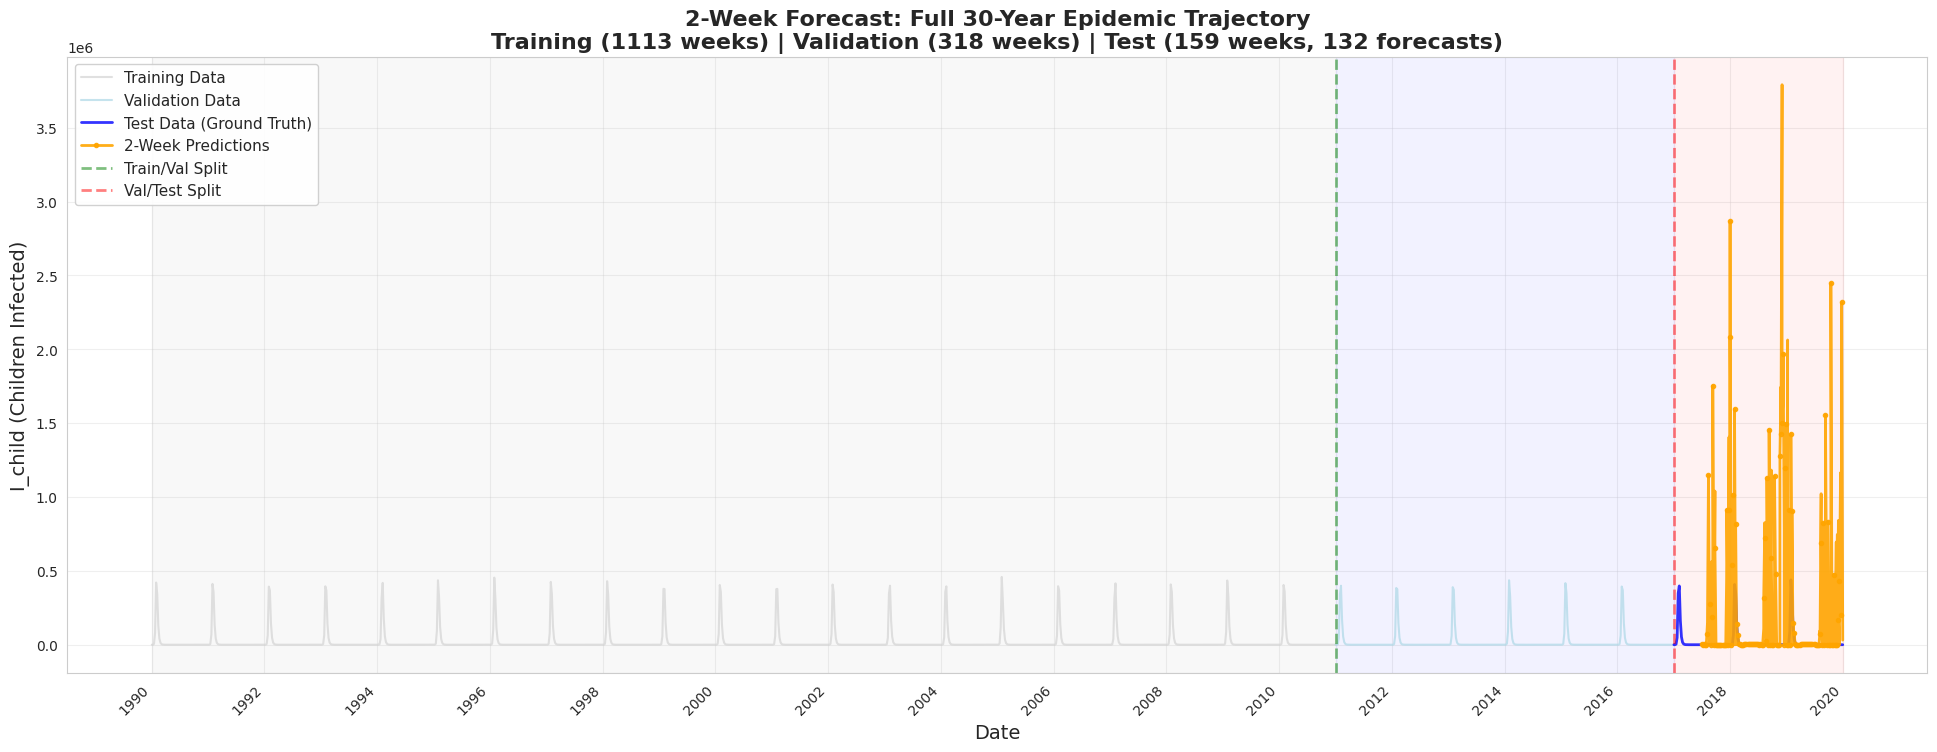

In [14]:
# =============================================================================
# PLOT 7: FULL TIME SERIES TRAJECTORY WITH FORECASTS
# =============================================================================

for horizon in HORIZONS:
    preds = results[horizon]['predictions']
    trues = results[horizon]['true_values']
    dates = results[horizon]['dates']
    
    # Flatten predictions and dates
    preds_flat = []
    dates_pred = []
    
    for i in range(len(preds)):
        for h in range(preds.shape[1]):
            preds_flat.append(preds[i, h, 0])
            dates_pred.append(dates[i][h])
    
    preds_flat = np.array(preds_flat)
    dates_pred = np.array(dates_pred)
    
    # Get full time series data (I_child column)
    target_col = 'I_child'
    full_dates = data_full['date'].values
    full_values = data_full[target_col].values
    
    # Calculate split indices
    train_end_idx = num_train
    val_end_idx = num_train + num_val
    
    fig, ax = plt.subplots(figsize=(24, 8))
    
    # Plot full time series with different colors for train/val/test
    # Train region
    ax.plot(full_dates[:train_end_idx], full_values[:train_end_idx], 
            label='Training Data', color='lightgray', linewidth=1.5, alpha=0.7)
    
    # Validation region
    ax.plot(full_dates[train_end_idx:val_end_idx], full_values[train_end_idx:val_end_idx], 
            label='Validation Data', color='lightblue', linewidth=1.5, alpha=0.7)
    
    # Test region (ground truth)
    ax.plot(full_dates[val_end_idx:], full_values[val_end_idx:], 
            label='Test Data (Ground Truth)', color='blue', linewidth=2, alpha=0.8)
    
    # Overlay predictions on test region
    ax.plot(dates_pred, preds_flat, 
            label=f'{horizon}-Week Predictions', color='orange', linewidth=2, 
            alpha=0.9, marker='o', markersize=3, markevery=horizon)
    
    # Add vertical lines to mark splits
    ax.axvline(x=full_dates[train_end_idx], color='green', linestyle='--', 
               linewidth=2, alpha=0.5, label='Train/Val Split')
    ax.axvline(x=full_dates[val_end_idx], color='red', linestyle='--', 
               linewidth=2, alpha=0.5, label='Val/Test Split')
    
    # Add shaded regions
    ax.axvspan(full_dates[0], full_dates[train_end_idx], 
               alpha=0.05, color='gray', label='_nolegend_')
    ax.axvspan(full_dates[train_end_idx], full_dates[val_end_idx], 
               alpha=0.05, color='blue', label='_nolegend_')
    ax.axvspan(full_dates[val_end_idx], full_dates[-1], 
               alpha=0.05, color='red', label='_nolegend_')
    
    ax.set_title(f'{horizon}-Week Forecast: Full 30-Year Epidemic Trajectory\n'
                 f'Training ({num_train} weeks) | Validation ({num_val} weeks) | '
                 f'Test ({num_test} weeks, {len(preds)} forecasts)', 
                 fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('I_child (Children Infected)', fontsize=14)
    ax.legend(fontsize=11, loc='upper left', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add annotation
    ax.text(0.02, 0.98, 
            f'Model Performance on Test Set:\n'
            f'MAE: {summary_data[HORIZONS.index(horizon)]["MAE"]}\n'
            f'R²: {summary_data[HORIZONS.index(horizon)]["R²"]}',
            transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(f'./results/full_trajectory_{horizon}week.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n{horizon}-week forecast full trajectory:")
    print(f"  Full data span: {full_dates[0]} to {full_dates[-1]}")
    print(f"  Train: {full_dates[0]} to {full_dates[train_end_idx-1]}")
    print(f"  Val:   {full_dates[train_end_idx]} to {full_dates[val_end_idx-1]}")
    print(f"  Test:  {full_dates[val_end_idx]} to {full_dates[-1]}")
    print(f"  Predictions: {dates_pred[0]} to {dates_pred[-1]}")


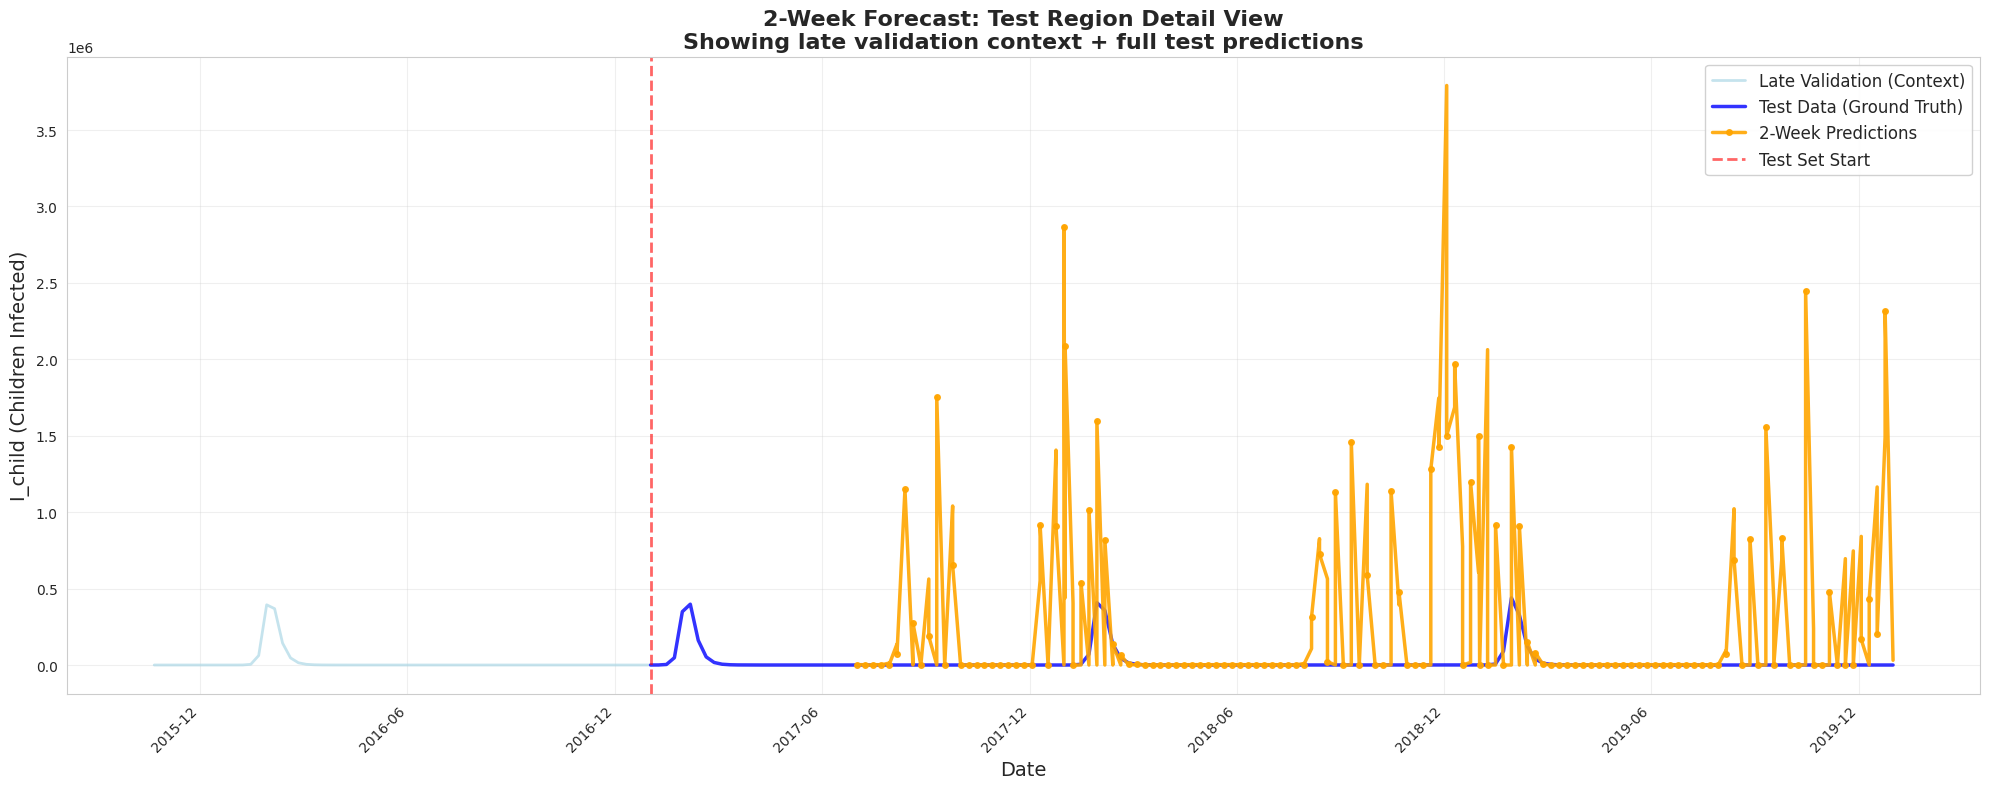

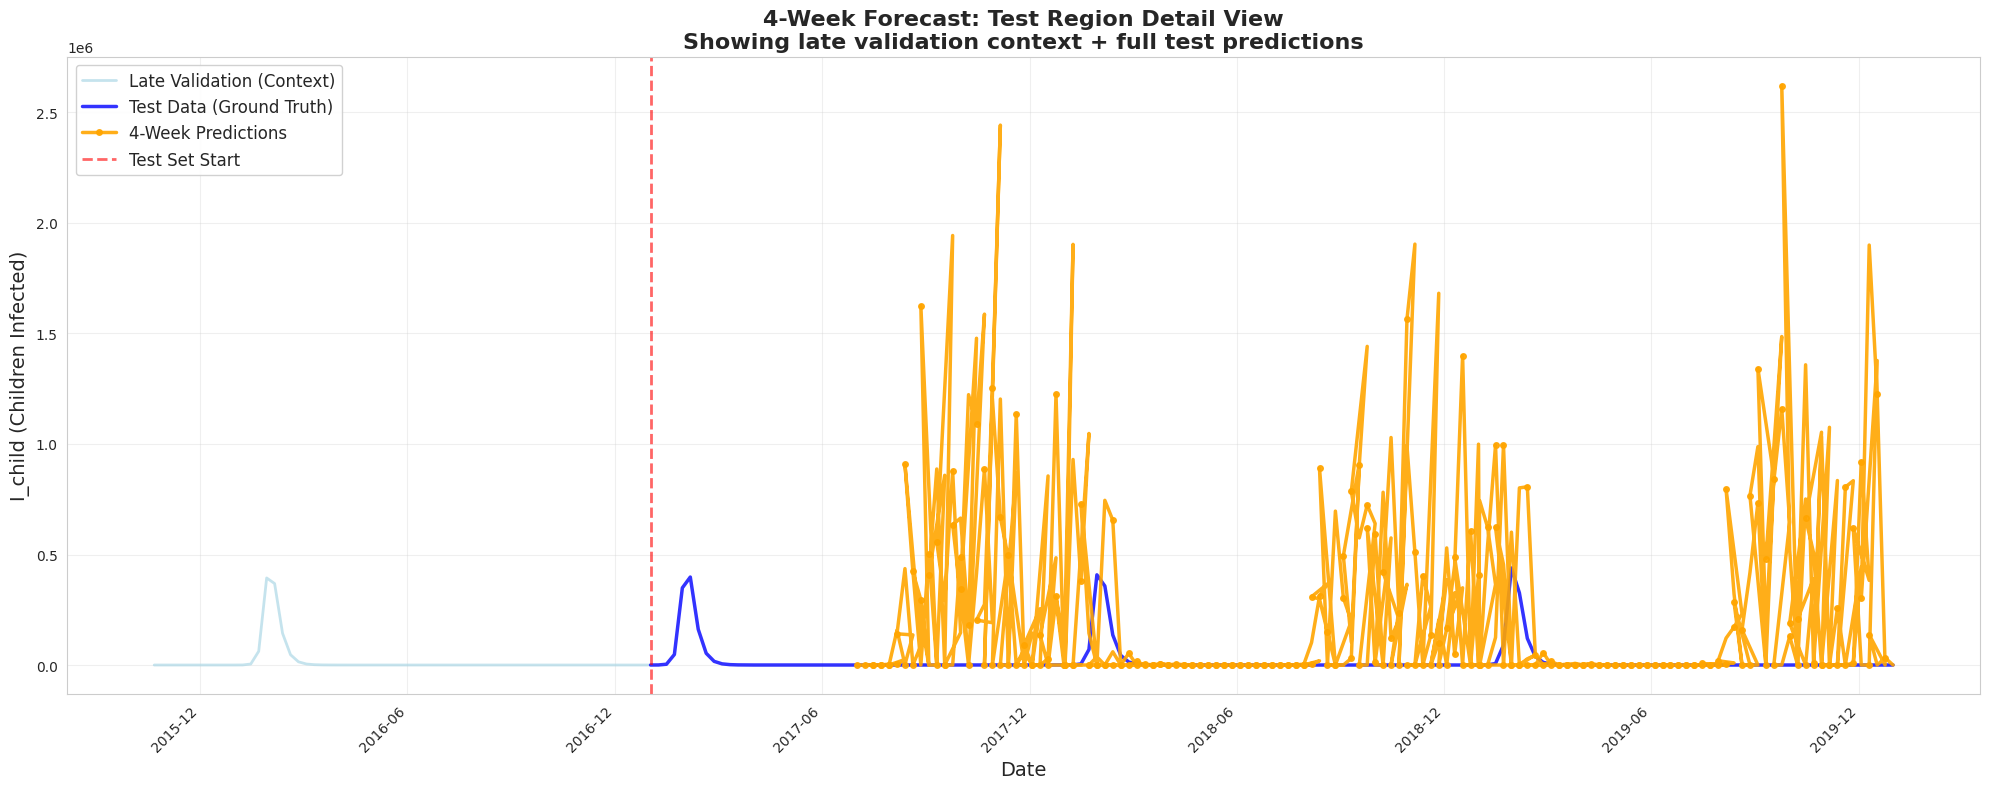

In [15]:
# =============================================================================
# PLOT 8: ZOOMED TEST REGION WITH CONTEXT
# =============================================================================

for horizon in HORIZONS:
    preds = results[horizon]['predictions']
    trues = results[horizon]['true_values']
    dates = results[horizon]['dates']
    
    # Flatten predictions and dates
    preds_flat = []
    dates_pred = []
    
    for i in range(len(preds)):
        for h in range(preds.shape[1]):
            preds_flat.append(preds[i, h, 0])
            dates_pred.append(dates[i][h])
    
    preds_flat = np.array(preds_flat)
    dates_pred = np.array(dates_pred)
    
    # Get target column
    target_col = 'I_child'
    
    # Define zoom window: last 20% of validation + all test
    zoom_start_idx = num_train + int(num_val * 0.8)
    zoom_dates = data_full['date'].iloc[zoom_start_idx:].values
    zoom_values = data_full[target_col].iloc[zoom_start_idx:].values
    
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Plot zoomed region
    # Late validation (context)
    val_zoom_end = num_train + num_val - zoom_start_idx
    ax.plot(zoom_dates[:val_zoom_end], zoom_values[:val_zoom_end], 
            label='Late Validation (Context)', color='lightblue', linewidth=2, alpha=0.7)
    
    # Test region (ground truth)
    ax.plot(zoom_dates[val_zoom_end:], zoom_values[val_zoom_end:], 
            label='Test Data (Ground Truth)', color='blue', linewidth=2.5, alpha=0.8)
    
    # Predictions
    ax.plot(dates_pred, preds_flat, 
            label=f'{horizon}-Week Predictions', color='orange', linewidth=2.5, 
            alpha=0.9, marker='o', markersize=4, markevery=max(1, len(preds)//50))
    
    # Mark test start
    ax.axvline(x=data_full['date'].iloc[num_train + num_val], 
               color='red', linestyle='--', linewidth=2, alpha=0.6, 
               label='Test Set Start')
    
    ax.set_title(f'{horizon}-Week Forecast: Test Region Detail View\n'
                 f'Showing late validation context + full test predictions', 
                 fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('I_child (Children Infected)', fontsize=14)
    ax.legend(fontsize=12, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(f'./results/test_region_detail_{horizon}week.png', dpi=300, bbox_inches='tight')
    plt.show()